### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 



In [1]:
import numpy as np
import h5py
from sklearn.manifold import Isomap
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline

### Data preparing

In [2]:
f = h5py.File('../working/copia di sicurezza.h5','r')
dset = []

for idx, name in enumerate(list(f.keys())):
    dset.append(f[name][0:1000])

dset = pd.DataFrame(np.transpose(dset))
dset.columns = list(f.keys())
dset

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,snr,z
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,0.0,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,2.139659
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,0.0,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,2.438707
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,0.0,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,1.869461
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0.0,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0.428061
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,1.0,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.576429,-0.645197,0.106358,0.779329,0.480224,0.302788,-0.164741,0.0,1.784171,905.125763,2.367827,0.466528,-0.034750,0.993533,3.260640
996,-0.134131,0.205700,-0.107687,-0.046215,0.361217,-0.813627,-1.245679,0.0,2.560637,264.862843,1.422802,0.642199,2.816555,3.599715,3.244858
997,0.216536,-0.100850,0.299994,0.088451,0.136617,-0.121935,1.036102,1.0,0.415292,408.083801,3.102616,0.756706,-1.027694,20.986058,1.004410
998,0.274411,-0.156249,-0.064642,0.302982,0.366175,0.325817,0.919502,0.0,2.010860,588.336562,3.114282,0.692634,-2.490513,2.113289,2.580256


Chosen dataset features to fit the various models/methods.

In [3]:
columns = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec','iota', 'mtot', 'psi', 'q', 'ra', 'z']

Splitting the dataset in training and testing (validating) dataset. Then, rescaling it in order to have mean zero and variance 1.
Firstly, I use as the labels/targets the "det" column, which contain binary counts (0 for undetected, 1 for detected signal). Therefore, I will use a Logistic Regression in order to predict whether my signal is observable (1), or not (0) for different scenarios. Then, I will substitute it with the "snr" column, which contains the exact snr value. Therefore, I will use a Random Forest Regressor, with a threshold SNR = 12 as a divider for the two classes.

In [4]:
scaler = StandardScaler().set_output(transform="pandas")
X_train, X_test, y_train, y_test = train_test_split(dset[columns], dset['det'], test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1. Logistic Regression on the Dataset (scaled and unscaled)

Firstly, I fit the Logistic Regressor directly on the dataset, both for the scaled and unscaled scenario.

In [5]:
Cs = np.logspace(-5, 5, 20)
unscaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
unscaled_clf.fit(X_train, y_train)
scaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
scaled_clf.fit(X_train_scaled, y_train)

print(f"Optimal C for the unscaled dataset: {unscaled_clf.C_[0]:.4f}\n")
print(f"Optimal C for the standardized dataset: {scaled_clf.C_[0]:.2f}")

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test_scaled)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test_scaled)

condition = (y_pred == y_test)
#print(X_test.shape, X_test[condition].shape)

condition = (y_pred_scaled == y_test)
#print(X_test_scaled.shape, X_test_scaled[condition].shape)

accuracy_unscaled = accuracy_score(y_test, y_pred)
f1_unscaled = f1_score(y_test, y_pred)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
f1_scaled = f1_score(y_test, y_pred_scaled)

Conf_matrix = confusion_matrix(y_test, y_pred_scaled)
tn, fp, fn, tp = Conf_matrix.ravel()
completeness_test_dataset= tp/(tp+fn)
contamination_test_dataset = fp/(tp+fp)

Optimal C for the unscaled dataset: 0.5456

Optimal C for the standardized dataset: 6.16


### 2. PCA + Logistic Regression on Dataset (scaled and unscaled)

Now, before fitting the data with a Logistic Regressor, I firstly apply a PCA on both the scaled and unscaled data.

In [6]:
pca = PCA(n_components=7)

Here I just visualize the first two components obtained from the PCA

(700, 7)


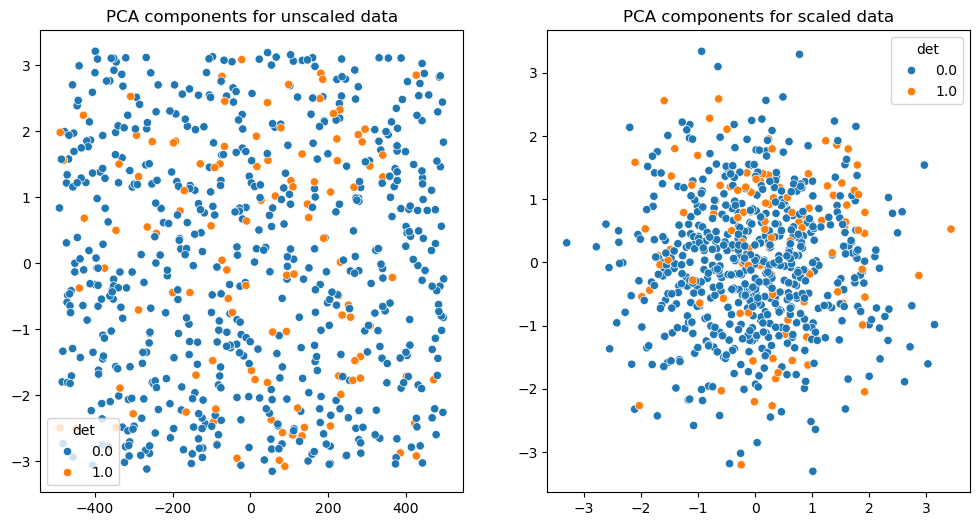

In [7]:
X_train_transformed = pca.fit_transform(X_train)
print(X_train_transformed.shape)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_train_transformed[:, 0], y = X_train_transformed[:,1], hue = y_train)
plt.title('PCA components for unscaled data')

X_train_transformed_scaled = pca.fit_transform(X_train_scaled)
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_train_transformed_scaled[:, 0], y = X_train_transformed_scaled[:,1], hue = y_train)
plt.title('PCA components for scaled data');

Then, I create a pipeline to fit the training subset with the different models and to predict the labels for the testing subset.

Optimal C for the unscaled PCA: 0.1624

Optimal C for the standardized data with PCA: 1.83


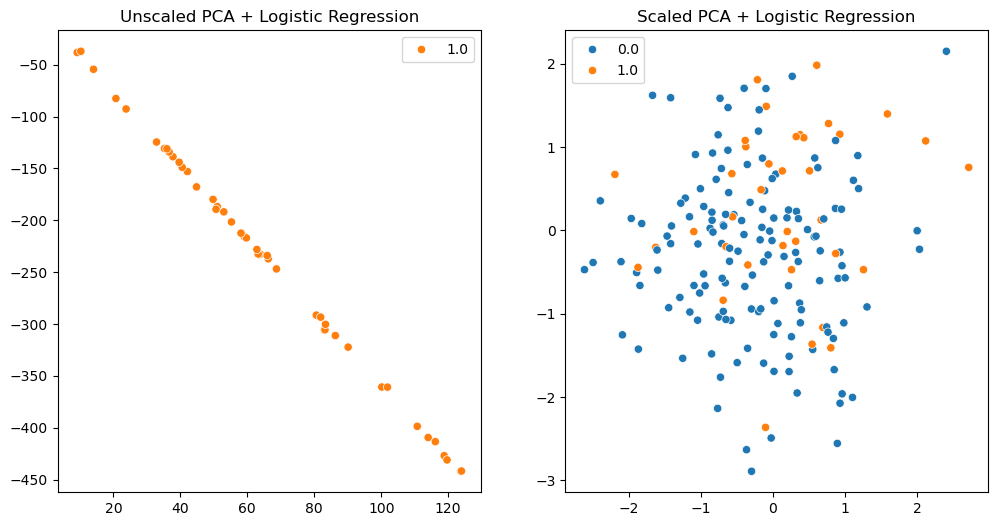

In [8]:
Cs = np.logspace(-5, 5, 20)
unscaled_clf = make_pipeline(pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
unscaled_clf.fit(X_train, y_train)
#Cs = np.linspace(-5, 15, 20)
scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
scaled_clf.fit(X_train, y_train) #since scaler and pca are both in the make_pipeline, I directly use X_train

print(f"Optimal C for the unscaled PCA: {unscaled_clf[-1].C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with PCA: {scaled_clf[-1].C_[0]:.2f}")

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test_scaled) #since scaler and pca are both in the make_pipeline, I directly use X_test
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test_scaled) #ibidem

Conf_matrix_PCA = confusion_matrix(y_test, y_pred_scaled)
tn, fp, fn, tp = Conf_matrix_PCA.ravel()
completeness_test_pca = tp/(tp+fn)
contamination_test_pca = fp/(tp+fp)

accuracy_unscaled_pca = accuracy_score(y_test, y_pred)
accuracy_scaled_pca = accuracy_score(y_test, y_pred_scaled)
f1_unscaled_pca= f1_score(y_test, y_pred)
f1_scaled_pca = f1_score(y_test, y_pred_scaled)

fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)

#for visualization purposes, I apply the pca outside also
X_test_transformed = pca.transform(X_test)
condition = (y_pred == y_test)
sns.scatterplot(x=X_test_transformed[condition][:,0], y = X_test_transformed[condition][:,1], hue=y_pred[condition], palette = [sns.color_palette("tab10")[1]])
plt.title('Unscaled PCA + Logistic Regression');

X_test_scaled_transformed = pca.transform(X_test_scaled)
ax2 = fig.add_subplot(1,2,2)
condition = (y_pred_scaled == y_test)
sns.scatterplot(x=X_test_scaled_transformed[condition][:,0], y = X_test_scaled_transformed[condition][:,1], hue=y_pred_scaled[condition])
plt.title('Scaled PCA + Logistic Regression');

### 3. Isomap + Logistic Regression on Dataset (scaled and unscaled)

Here, I substitute the previous PCA with an Isomap embedding.

In [9]:
embedding = Isomap(n_components=7)
X_train_scaled_isomap = embedding.fit_transform(X_train_scaled)
print(X_train_scaled_isomap.shape)

(700, 7)


Again, I firstly visualize the first two components obtained from the embedding of the training dataset (scaled and unscaled).

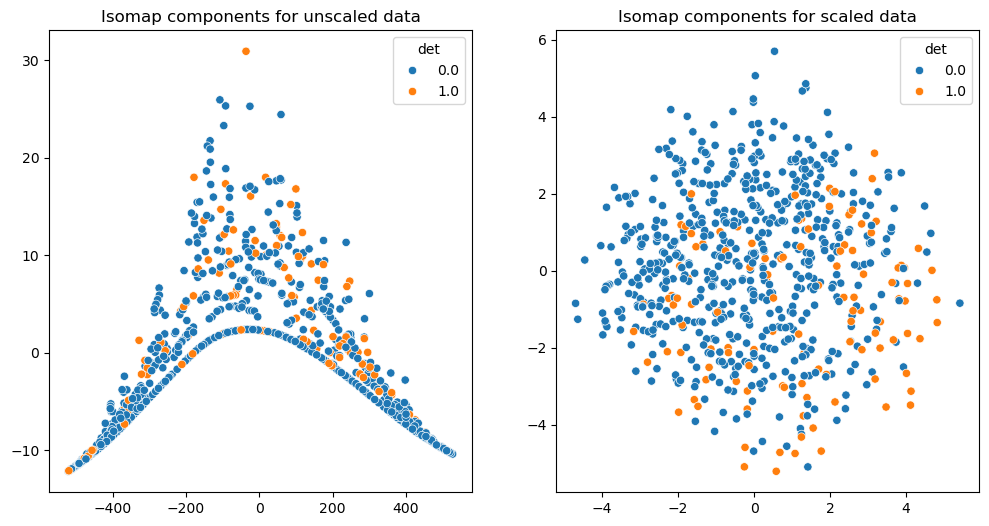

In [10]:
embedding = Isomap(n_components=7, n_neighbors=10)

X_train_isomap = embedding.fit_transform(X_train)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_train_isomap[:, 0], y = X_train_isomap[:,1], hue = y_train)
plt.title('Isomap components for unscaled data')

X_train_scaled_isomap = embedding.fit_transform(X_train_scaled)
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_train_scaled_isomap[:, 0], y = X_train_scaled_isomap[:,1], hue = y_train)
plt.title('Isomap components for scaled data');

Then, I use the embedded training subset to fit the Logistic regressor. Finally, I compute the model predictions on the embedded testing subset.

Optimal C for the unscaled Isomap: 0.0000

Optimal C for the standardized data with Isomap: 0.16


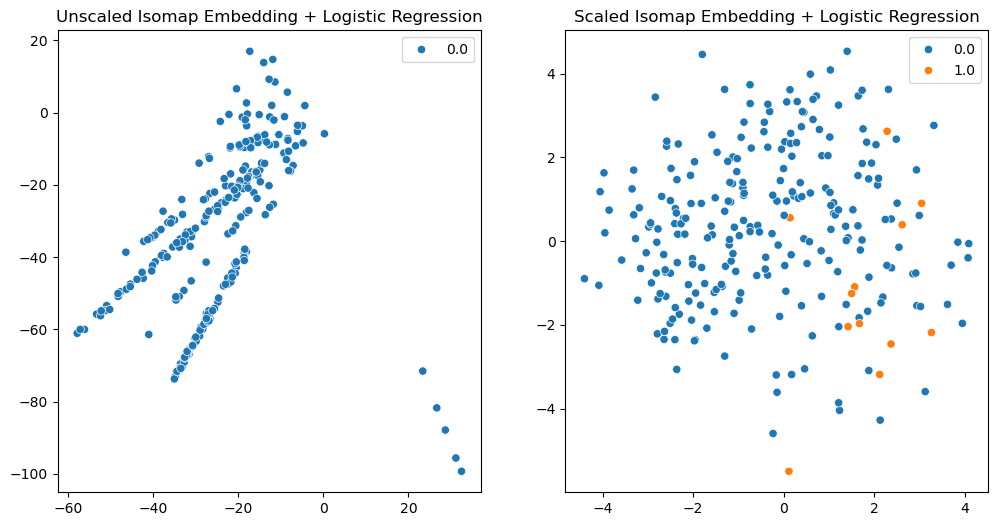

In [11]:
Cs = np.logspace(-5, 5, 20)
unscaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
unscaled_clf.fit(X_train_isomap, y_train)
scaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
scaled_clf.fit(X_train_scaled_isomap, y_train)

print(f"Optimal C for the unscaled Isomap: {unscaled_clf.C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with Isomap: {scaled_clf.C_[0]:.2f}")

X_test_isomap = embedding.transform(X_test)
X_test_isomap_scaled = embedding.transform(X_test_scaled)
y_pred = unscaled_clf.predict(X_test_isomap)
y_pred_scaled = scaled_clf.predict(X_test_isomap_scaled)
y_proba = unscaled_clf.predict_proba(X_test_isomap)
y_proba_scaled = scaled_clf.predict_proba(X_test_isomap_scaled)

Conf_matrix_Isomap = confusion_matrix(y_test, y_pred_scaled)
tn, fp, fn, tp = Conf_matrix_Isomap.ravel()
completeness_test_isomap = tp/(tp+fn)
contamination_test_isomap = fp/(tp+fp)

accuracy_unscaled_isomap = accuracy_score(y_test, y_pred)
accuracy_scaled_isomap = accuracy_score(y_test, y_pred_scaled)
f1_unscaled_isomap= f1_score(y_test, y_pred)
f1_scaled_isomap = f1_score(y_test, y_pred_scaled)

fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)

condition = (y_pred == y_test)
sns.scatterplot(x=X_test_isomap[condition][:,0], y = X_test_isomap[condition][:,1], hue=y_pred[condition])
plt.title('Unscaled Isomap Embedding + Logistic Regression')

ax2 = fig.add_subplot(1,2,2)
condition = (y_pred_scaled == y_test)
sns.scatterplot(x=X_test_isomap_scaled[condition][:,0], y = X_test_isomap_scaled[condition][:,1], hue=y_pred_scaled[condition])
plt.title('Scaled Isomap Embedding + Logistic Regression');

### 4. Random Forest Regressor on the Dataset (scaled and unscaled)
In this section, I tried using a regressor on the SNR column instead of a classifier on the column det, containing binary counts. In particular, I used the Random Forest Regressor.

Therefore, I redefined my training, testing subsets and their corresponding labels/targets.

In [12]:
scaler = StandardScaler().set_output(transform="pandas")
X_train, X_test, y_train, y_test = train_test_split(dset[columns], dset['snr'], test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Then, I train the regressor on both the unscaled and the scaled datasets, comparing the performances of each on the corresponding testing subset.

In [13]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#Since the prediction returns me a value of the SNR
#I define a threshold to determine whether my
#model returns a detectable or undetectable signal.
y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rfr = accuracy_score(y_test_class, y_pred_class)
f1_rfr = f1_score(y_test_class, y_pred_class)


In [14]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rfr_scaled = accuracy_score(y_test_class, y_pred_class)
f1_rfr_scaled = f1_score(y_test_class, y_pred_class)

Conf_matrix_rfr = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = Conf_matrix_rfr.ravel()
completeness_test_rfr = tp/(tp+fn)
contamination_test_rfr = fp/(tp+fp)

### 5. PCA + Random Forest Regression on Dataset (scaled and unscaled)

In [15]:
pca = PCA(n_components = 7)

unscaled_clf = make_pipeline(pca, RandomForestRegressor(random_state=42))
unscaled_clf.fit(X_train, y_train)

y_pred = unscaled_clf.predict(X_test)

y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rfr_pca = accuracy_score(y_test_class, y_pred_class)
f1_rfr_pca = f1_score(y_test_class, y_pred_class)

scaled_clf = make_pipeline(scaler, pca, RandomForestRegressor(random_state=42))
scaled_clf.fit(X_train, y_train)

y_pred = scaled_clf.predict(X_test)

y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rfr_pca_scaled = accuracy_score(y_test_class, y_pred_class)
f1_rfr_pca_scaled = f1_score(y_test_class, y_pred_class)

Conf_matrix_rfr_pca = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = Conf_matrix_rfr_pca.ravel()
completeness_test_rfr_pca = tp/(tp+fn)
contamination_test_rfr_pca = fp/(tp+fp)

### 6. Isomap + Random Forest Regression on Dataset (scaled and unscaled)

In [16]:
embedding = Isomap(n_components=7, n_neighbors=10)

X_train_embedded = embedding.fit_transform(X_train)
unscaled_clf = RandomForestRegressor(random_state=42)
unscaled_clf.fit(X_train_embedded, y_train)

X_test_embedded = embedding.transform(X_test)
y_pred = unscaled_clf.predict(X_test_embedded)

y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rfr_isomap = accuracy_score(y_test_class, y_pred_class)
f1_rfr_isomap = f1_score(y_test_class, y_pred_class)

X_train_scaled_embedded = embedding.fit_transform(X_train_scaled)
scaled_clf = RandomForestRegressor(random_state=42)
scaled_clf.fit(X_train_scaled_embedded, y_train)

X_test_scaled_embedded = embedding.transform(X_test_scaled)
y_pred = scaled_clf.predict(X_test_scaled_embedded)

y_pred_class = (y_pred > 12).astype(int)
y_test_class = (y_test > 12).astype(int)

accuracy_rfr_isomap_scaled = accuracy_score(y_test_class, y_pred_class)
f1_rfr_isomap_scaled = f1_score(y_test_class, y_pred_class)

Conf_matrix_rfr_isomap = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = Conf_matrix_rfr_isomap.ravel()
completeness_test_rfr_isomap = tp/(tp+fn)
contamination_test_rfr_isomap = fp/(tp+fp)

### 7. Comparison between the Models Performances

In this section, I compare the results obtained from the different analysis. Specifically, I computed for each case the accuracy score, the confusion matrix, the completeness and the contamination values.

#### Accuracy Comparison

In [17]:
print('------------- LOGISTIC REGRESSION PERFORMANCES -----------')
print('Test accuracy for the unscaled dataset: %.02f' %accuracy_unscaled)
print('Test accuracy for the standardized dataset: %.02f' %accuracy_scaled)

print("Test accuracy for the unscaled PCA: %.02f" %accuracy_unscaled_pca)
print("Test accuracy for the standardized data with PCA: %.02f" %accuracy_scaled_pca)

print("Test accuracy for the unscaled ISOMAP: %.02f" %accuracy_unscaled_isomap)
print("Test accuracy for the standardized data with ISOMAP: %.02f" %accuracy_scaled_isomap)

print('\n------------- RANDOM FOREST REGRESSION PERFORMANCES -----------')
print('Test accuracy for the unscaled dataset: %.02f' %accuracy_rfr)
print('Test accuracy for the standardized dataset: %.02f' %accuracy_rfr_scaled)

print("Test accuracy for the unscaled PCA: %.02f" %accuracy_rfr_pca)
print("Test accuracy for the standardized data with PCA: %.02f" %accuracy_rfr_pca_scaled)

print("Test accuracy for the unscaled ISOMAP: %.02f" %accuracy_rfr_isomap)
print("Test accuracy for the standardized data with ISOMAP: %.02f" %accuracy_rfr_isomap_scaled)

------------- LOGISTIC REGRESSION PERFORMANCES -----------
Test accuracy for the unscaled dataset: 0.89
Test accuracy for the standardized dataset: 0.95
Test accuracy for the unscaled PCA: 0.15
Test accuracy for the standardized data with PCA: 0.61
Test accuracy for the unscaled ISOMAP: 0.85
Test accuracy for the standardized data with ISOMAP: 0.85

------------- RANDOM FOREST REGRESSION PERFORMANCES -----------
Test accuracy for the unscaled dataset: 0.96
Test accuracy for the standardized dataset: 0.96
Test accuracy for the unscaled PCA: 0.96
Test accuracy for the standardized data with PCA: 0.78
Test accuracy for the unscaled ISOMAP: 0.58
Test accuracy for the standardized data with ISOMAP: 0.76


#### F1 Score Comparison

Since the dataset is modestly imbalanced, the accuracy is not the best metric to evaluate the performance of the various model. In order to understand how well the different models can predict both these classes (and for instance not considering all data not detectable and still obtaining an high accuracy) I also computed the F1 score metric. The latter, in fact, is adeguate to evaluate binary predictions. We can see this by looking at the ISOMAP with a Logistic Regression: the accuracy is basically the same, but the F1 score is basically zero for the unscaled isomap, because it only determines everything as undetectable - therefore, has zero precision on the detectable class.

In [18]:
print('------------- LOGISTIC REGRESSION PERFORMANCES -----------')
print('Test F1score for the unscaled dataset: %.02f' %f1_unscaled)
print('Test F1score for the standardized dataset: %.02f' %f1_scaled)

print("Test F1score for the unscaled PCA: %.02f" %f1_unscaled_pca)
print("Test F1score for the standardized data with PCA: %.02f" %f1_scaled_pca)

print("Test F1score for the unscaled ISOMAP: %.02f" %f1_unscaled_isomap)
print("Test F1score for the standardized data with ISOMAP: %.02f" %f1_scaled_isomap)

print('\n------------- RANDOM FOREST REGRESSION PERFORMANCES -----------')
print('Test F1score for the unscaled dataset: %.02f' %f1_rfr)
print('Test F1score for the standardized dataset: %.02f' %f1_rfr_scaled)

print("Test F1score for the unscaled PCA: %.02f" %f1_rfr_pca)
print("Test F1score for the standardized data with PCA: %.02f" %f1_rfr_pca_scaled)

print("Test F1score for the unscaled ISOMAP: %.02f" %f1_rfr_isomap)
print("Test F1score for the standardized data with ISOMAP: %.02f" %f1_rfr_isomap_scaled)

------------- LOGISTIC REGRESSION PERFORMANCES -----------
Test F1score for the unscaled dataset: 0.40
Test F1score for the standardized dataset: 0.86
Test F1score for the unscaled PCA: 0.26
Test F1score for the standardized data with PCA: 0.39
Test F1score for the unscaled ISOMAP: 0.00
Test F1score for the standardized data with ISOMAP: 0.35

------------- RANDOM FOREST REGRESSION PERFORMANCES -----------
Test F1score for the unscaled dataset: 0.87
Test F1score for the standardized dataset: 0.87
Test F1score for the unscaled PCA: 0.87
Test F1score for the standardized data with PCA: 0.49
Test F1score for the unscaled ISOMAP: 0.26
Test F1score for the standardized data with ISOMAP: 0.48


#### Completeness comparison

In [19]:
print('------------- LOGISTIC REGRESSION PERFORMANCES -----------')
print('Completeness for scaled dataset: %0.2f' % completeness_test_dataset)
print('Completeness for scaled PCA: %0.2f' % completeness_test_pca)
print('Completeness for scaled Isomap: %0.2f' %completeness_test_isomap)

print('\n------------- RANDOM FOREST REGRESSION PERFORMANCES -----------')
print('Completeness for scaled dataset: %0.2f' % completeness_test_rfr)
print('Completeness for scaled PCA: %0.2f' % completeness_test_rfr_pca)
print('Completeness for scaled Isomap: %0.2f' %completeness_test_rfr_isomap)

------------- LOGISTIC REGRESSION PERFORMANCES -----------
Completeness for scaled dataset: 0.98
Completeness for scaled PCA: 0.84
Completeness for scaled Isomap: 0.27

------------- RANDOM FOREST REGRESSION PERFORMANCES -----------
Completeness for scaled dataset: 0.98
Completeness for scaled PCA: 0.73
Completeness for scaled Isomap: 0.75


#### Contamination comparison

In [20]:
print('------------- LOGISTIC REGRESSION PERFORMANCES -----------')
print('Contamination for scaled dataset: %0.2f' % contamination_test_dataset)
print('Contamination for scaled PCA: %0.2f' % contamination_test_pca)
print('Contamination for scaled Isomap: %0.2f' %contamination_test_isomap)

print('\n------------- RANDOM FOREST REGRESSION PERFORMANCES -----------')
print('Contamination for scaled dataset: %0.2f' % contamination_test_rfr)
print('Contamination for scaled PCA: %0.2f' % contamination_test_rfr_pca)
print('Contamination for scaled Isomap: %0.2f' %contamination_test_rfr_isomap)

------------- LOGISTIC REGRESSION PERFORMANCES -----------
Contamination for scaled dataset: 0.23
Contamination for scaled PCA: 0.75
Contamination for scaled Isomap: 0.52

------------- RANDOM FOREST REGRESSION PERFORMANCES -----------
Contamination for scaled dataset: 0.22
Contamination for scaled PCA: 0.63
Contamination for scaled Isomap: 0.65


#### Confusion Matrices Comparison

In [21]:
def plot_cm(conf_mat, case_name, ax = ax):
  sns.heatmap(conf_mat, annot=True, fmt="d", ax = ax)
  plt.title('Confusion matrix for ' +case_name)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


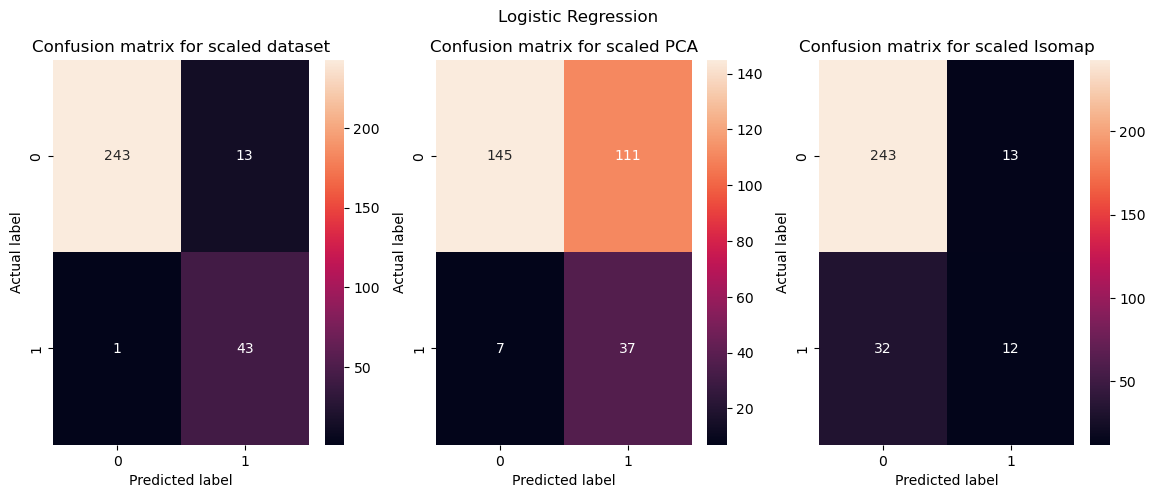

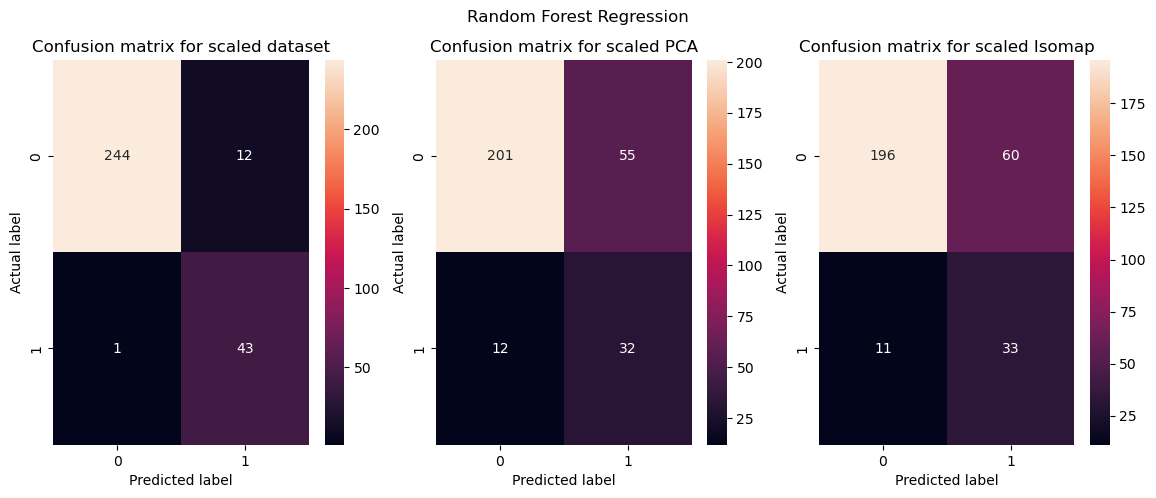

In [22]:
fig = plt.figure(figsize = (14,5))
plt.suptitle('Logistic Regression')
ax = fig.add_subplot(131)
plot_cm(Conf_matrix, case_name = 'scaled dataset', ax = ax)
ax = fig.add_subplot(132)
plot_cm(Conf_matrix_PCA, case_name = 'scaled PCA', ax = ax)
ax = fig.add_subplot(133)
plot_cm(Conf_matrix_Isomap, case_name = 'scaled Isomap', ax = ax)
plt.show()

fig = plt.figure(figsize = (14,5))
plt.suptitle('Random Forest Regression')
ax = fig.add_subplot(131)
plot_cm(Conf_matrix_rfr, case_name = 'scaled dataset', ax = ax)
ax = fig.add_subplot(132)
plot_cm(Conf_matrix_rfr_pca, case_name = 'scaled PCA', ax = ax)
ax = fig.add_subplot(133)
plot_cm(Conf_matrix_rfr_isomap, case_name = 'scaled Isomap', ax = ax)

### 8. Conclusions

From the results obtained, we can see that applying a PCA or a Isomap to the dataset is actually worsening the performance of the Logistic Regressor. However, using a regressor on the actual value of the SNR instead of a classifier on the detectable column results in a better performance on the testing dataset.